In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar, curve_fit
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [2]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [3]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [4]:
def w_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    w_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating graph weights: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        w_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    w = csr_matrix((w_ij.ravel(), (row_indices, neighbors.ravel())))
    return w + w.transpose() - (w.multiply(w.transpose()))

In [5]:
def w_ij_sym_exact(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(x)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    w_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating graph weights: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        dists, nn = nbrs.kneighbors([xi])
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        w_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    w = csr_matrix((w_ij.ravel(), (row_indices, neighbors.ravel())))
    return w + w.transpose() - (w.multiply(w.transpose()))

In [6]:
def pdiff(x):
    batch_size = x.shape[0] 
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)  
    return diffs

In [74]:
def attractive_force(diffs, w, a, b):
    sq_norms = diffs.pow(2).sum(axis=2)
    torch.diagonal(sq_norms).fill_(1.)
    sq_norms = sq_norms.unsqueeze(2)
    w = w.unsqueeze(2)
    return (-2*a*b*sq_norms.pow(b-1) / (1 + sq_norms) * (w * diffs))

In [75]:
def repulsive_force(diffs, w, b, eps=0.001):
    sq_norms = diffs.pow(2).sum(axis=2).unsqueeze(2)
    w = w.unsqueeze(2)
    return (b / (eps + sq_norms) / (1 + sq_norms) * (1 - w) * diffs)

In [76]:
def total_force(diffs, w, a, b, eps=0.001):
    attr = attractive_force(diffs, w, a, b)
    repl = repulsive_force(diffs, w, a, b)
    tot = attr + repl
    return tot.sum(dim=(0,1)).norm()

In [60]:
def find_ab_params(spread, min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]

In [61]:
def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [67]:
class Parametric_UMAP(nn.Module):
    
    def __init__(self, input_dim, output_dim, knn, min_dist,
                 spread=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.knn = knn
        self.min_dist = min_dist
        self.spread = spread
        
        self.a, self.b = find_ab_params(self.spread, self.min_dist)
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out = self.layers[-1](x)
        return out
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')
        pca = torch.tensor(PCA(n_components=2).fit_transform(training_data), dtype=training_data.dtype)
        
        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            w_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.w_ij = w_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
            
        if self.w_ij is None:
            self.w_ij = w_ij_sym(training_data.numpy(), self.knn, verbose=verbose)
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                w = submatrix(self.w_ij, indices.numpy())
                    
                if self.use_cuda:
                    features = features.cuda()
                    w = w.cuda()
                    
                optim.zero_grad()
                
                diffs = pdiff(self(features))
                loss = total_force(diffs, w, self.a, self.b)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

-----------------------

In [68]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [69]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [98]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

In [105]:
foo = Parametric_UMAP(28*28, 2, 100, 0.01, use_cuda=True, hidden_layer_dims=[300,100])

In [106]:
outdata = foo.forward(testdata.cuda())

In [115]:
total_force(pdiff(outdata[:500]).cpu(), torch.tensor(w_precalc[:500,:500].toarray()), foo.a, foo.b)

tensor(2.2076e-12, dtype=torch.float64, grad_fn=<NormBackward0>)

In [85]:
foo.fit(testdata[:20000], w_ij=w_precalc, batch_size=500, epochs=20, learning_rate=0.1, pretrain=False, verbose=True)

2020-01-08 10:51:10.833385: Beginning training for 20 epochs
2020-01-08 10:51:12.742692: Loss after epoch 1: 1.4212641080188644e-12
2020-01-08 10:51:14.723656: Loss after epoch 2: 1.2912623579698178e-12
2020-01-08 10:51:16.680343: Loss after epoch 3: 1.2731280536686225e-12
2020-01-08 10:51:18.593030: Loss after epoch 4: 1.4229211680467761e-12
2020-01-08 10:51:20.562886: Loss after epoch 5: 1.3823617583014731e-12


KeyboardInterrupt: 

In [77]:
w_precalc = foo.w_ij

In [81]:
bar = foo(testdata[:10000].cuda()).cpu().detach().numpy()

In [82]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

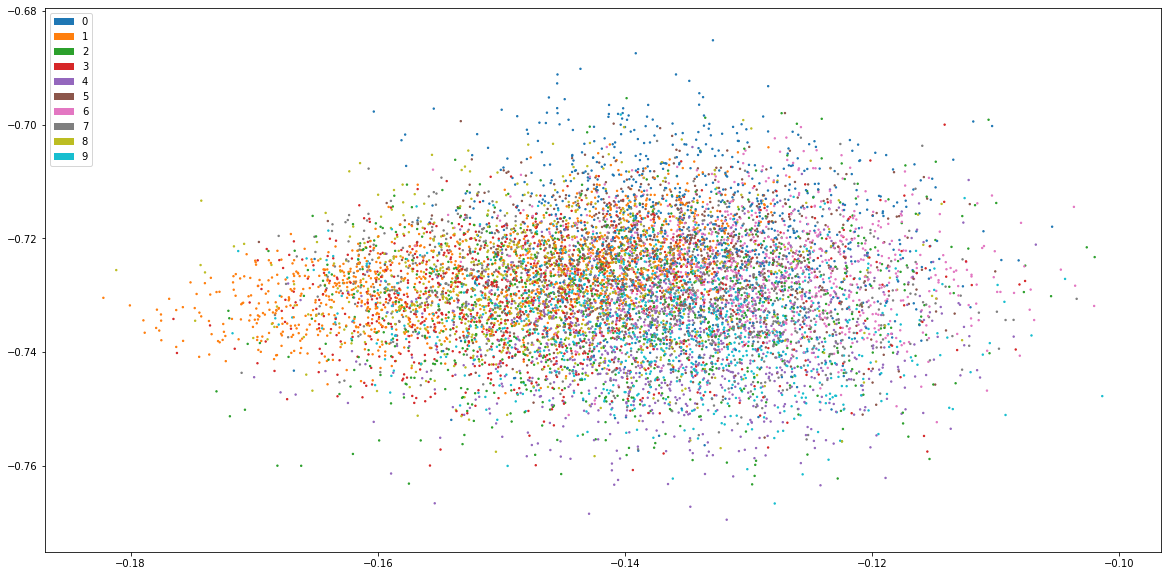

In [83]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:10000]]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)